# RESEARCH PAPER IMPLEMENTATION WITH SOME MODIFICATIONS

 First, preprocessing and augmentation algorithms were applied to MRI brain images. Next, we developed a new 2D Convolutional Neural Network (CNN), trained by our assigned hyperparameters. Then 2D CNN includes several convolution layers; all layers in this hierarchical network have a 2*2 kernel function. This network consists of eight convolutional and four pooling layers, and after all convolution layers, batch-normalization layers were applied.
 Modifications: Saving the best model while monitoring validation accuracy during training; ReduceLROnPlateau callback is introduces to reduce the larning rate after a non improvement of patience 2, with minimum difference of 0.001 and whith factor of 0.3, training for 12 epochs instead of 100.

 
 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard


In [7]:
for dirname, _, filenames in os.walk('Seminar'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

To call colors while plotting graphs

In [8]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

# sns.palplot(colors_dark)
# sns.palplot(colors_green)
# sns.palplot(colors_red)

In [9]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

Read the Images and Resizing to 80 x 80

In [10]:
X_train = []
y_train = []
image_size = 80
for i in labels:
    folderPath = os.path.join('Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 118.25it/s]


Take random shuffles images from the training set

In [11]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

Split the training and testing data into 90% for training and 10% for testing

In [12]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

Applying Data Augmentation with 90 degree rotation and vertical flipping of images and adding them to original sample to increase the size and reduce overfitting with batch size of 16

In [13]:
# Data Augmentation
datagen = ImageDataGenerator(rotation_range=90, vertical_flip=True)

# Augment the training data and concatenate the original data with augmented data
X_train_augmented, y_train_augmented = [], []

for batch_X, batch_y in datagen.flow(X_train, y_train, batch_size=16, shuffle=False):
    X_train_augmented.append(batch_X)
    y_train_augmented.append(batch_y)
    if len(X_train_augmented) * 16 >= len(X_train):  # Stop after augmenting enough samples
        break

X_train_augmented = np.concatenate(X_train_augmented, axis=0)
y_train_augmented = np.concatenate(y_train_augmented, axis=0)

# Concatenate original and augmented data
X_train = np.concatenate((X_train, X_train_augmented), axis=0)
y_train = np.concatenate((y_train, y_train_augmented), axis=0)

Use one hot encoding to convert the target variable to categorical values for better classfication and interpretation

In [14]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

Defining the CNN model with 8 Convolutional layers with 64 , 32, 16 2x2 filters, a maxpooling layer after 2 convolutions to reduce the feature map size with 2x2 filter , Batch Normalization to reduce the ICS or speeed up convergence, Dropout layer to reduce overfitting with rate 0.1

In [15]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

input_img = Input(shape=(80, 80, 3))  
# 2D CNN Layers
x = Conv2D(64, (2, 2), activation='relu', padding='same')(input_img)
x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Fully connected layers
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)

# Output layer
output = Dense(4, activation='softmax')(x)  # Adjust the number of classes if needed (4 classes here)

# Create the model
cnn_model = Model(inputs=input_img, outputs=output)

In [16]:
cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 80, 80, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 80, 80, 64)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 32)     │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 32)     │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 16)     │         2,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 20, 20, 16)     │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 10, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,639,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,676,708 (6.40 MB)

 Trainable params: 1,676,484 (6.40 MB)

 Non-trainable params: 224 (896.00 B)

In [17]:
cnn_model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

Saving the best model while monitoring validation accuracy during training; ReduceLROnPlateau callback is introduces to reduce the larning rate after a non improvement of patience 2, with minimum difference of 0.001 and whith factor of 0.3

In [18]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("model2_cnn.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

Training the model with 32 batch size for 12 epochs while monitoring the validation accuracy

In [19]:
history = cnn_model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.5478 - loss: 1.3456
Epoch 1: val_accuracy improved from -inf to 0.46939, saving model to model2_cnn.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 53s 271ms/step - accuracy: 0.5482 - loss: 1.3438 - val_accuracy: 0.4694 - val_loss: 1.2477 - learning_rate: 0.0010
Epoch 2/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.7579 - loss: 0.6055
Epoch 2: val_accuracy improved from 0.46939 to 0.66667, saving model to model2_cnn.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 55s 332ms/step - accuracy: 0.7579 - loss: 0.6055 - val_accuracy: 0.6667 - val_loss: 0.8642 - learning_rate: 0.0010
Epoch 3/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.8240 - loss: 0.4509
Epoch 3: val_accuracy improved from 0.66667 to 0.70238, saving model to model2_cnn.keras
166/166 ━━━━━━━━━━━━━━━━━━━━ 57s 343ms/step - accuracy: 0.8241 - loss: 0.4509 - val_accuracy: 0.7024 - val_loss: 0.7693 - learning_rate: 0.0010
Epoch 4/12
166/166 ━━━━━━━━━━━━━━━━━━━━ 

Plotting the Training and validation loss and accuracy

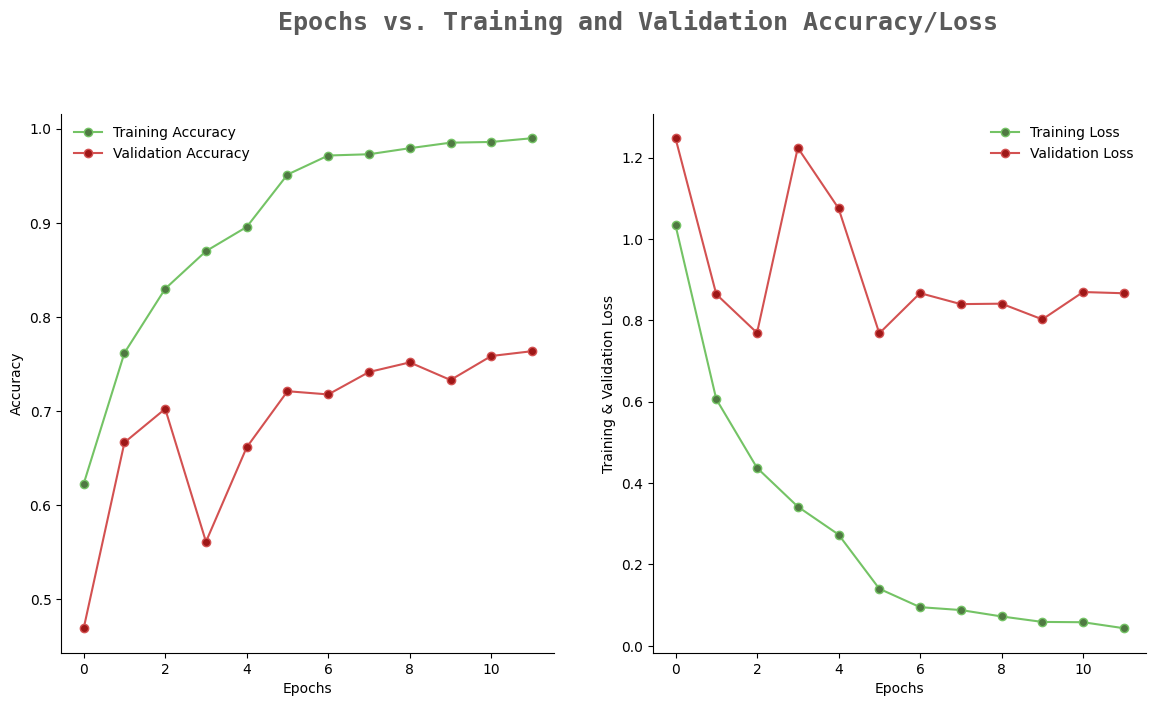

In [21]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

From the Graph we see that the model is trained well with consistent increasing and decreasing of training accuracy and loss respectively. However in Validation the model fluctuates on 3rd epoch and therefore after reducing the Learning rate it is then stable and consistent.

Prediction on Test Set using predicted values

In [22]:
pred = cnn_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


In [23]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90        93
           1       0.94      0.92      0.93        51
           2       0.85      0.97      0.91        96
           3       0.99      1.00      0.99        87

    accuracy                           0.93       327
   macro avg       0.94      0.93      0.93       327
weighted avg       0.94      0.93      0.93       327



Report shows that the prediction for each class(0,1,2,3) is nearly accurate with the highest precision for class 3 which is 0.99 . 

Confusion matrix to visualize result for each class, see the number of true and false labels correctly predicted

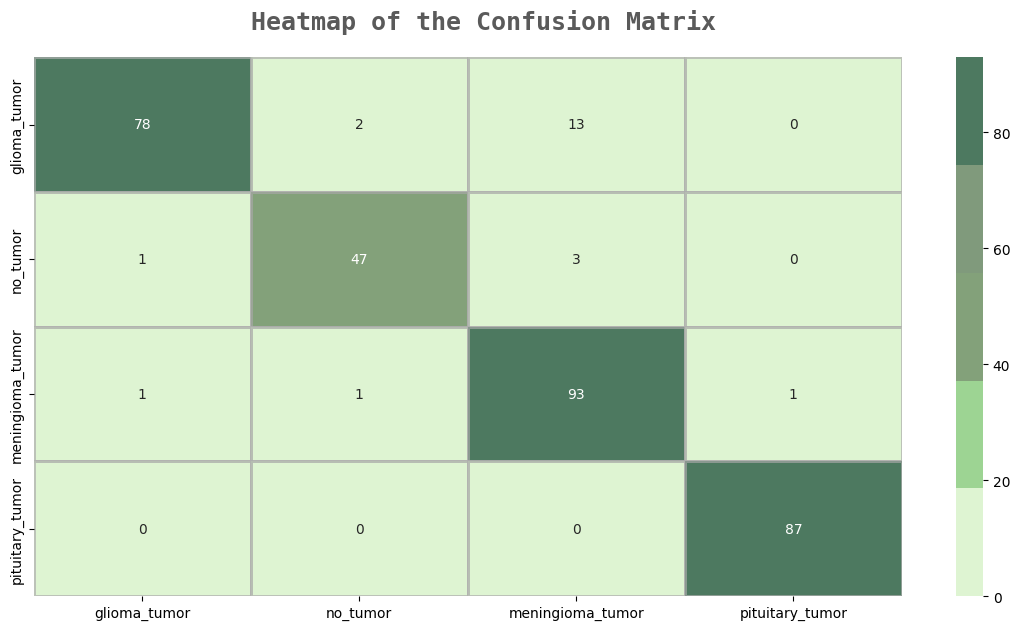

In [24]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [25]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test_new, pred)

print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 93.27%


The paper had the training accuracy of 96% and we have accuracy of 97% indicating our model is learning better


In [26]:
train_eval = cnn_model.evaluate(X_train, y_train)
print(f"Training Set Accuracy: {train_eval[1] * 100:.2f}%")

184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9972 - loss: 0.0165
Training Set Accuracy: 97.43%


The Model Accuracy for the Paper implementation was 93% and we have 93% also which is a good sign

In [28]:
# CNN Evaluation
cnn_eval = cnn_model.evaluate(X_test, y_test)
print(f"2D CNN Model Accuracy: {cnn_eval[1] * 100:.2f}%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9449 - loss: 0.2084
2D CNN Model Accuracy: 93.27%


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


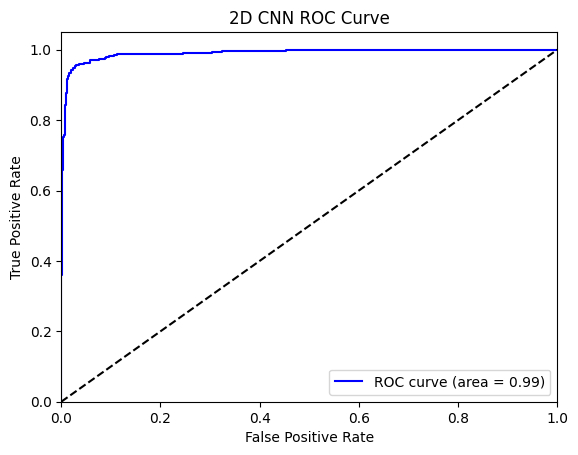

In [29]:
# ROC Curve for CNN
fpr, tpr, _ = roc_curve(y_test.ravel(), cnn_model.predict(X_test).ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('2D CNN ROC Curve')
plt.legend(loc="lower right")
plt.show()

Plotting ROC curve for each class, and obsering that the left hand side the curves are curved nicely indicating good learning and prediction of the moel for each class

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


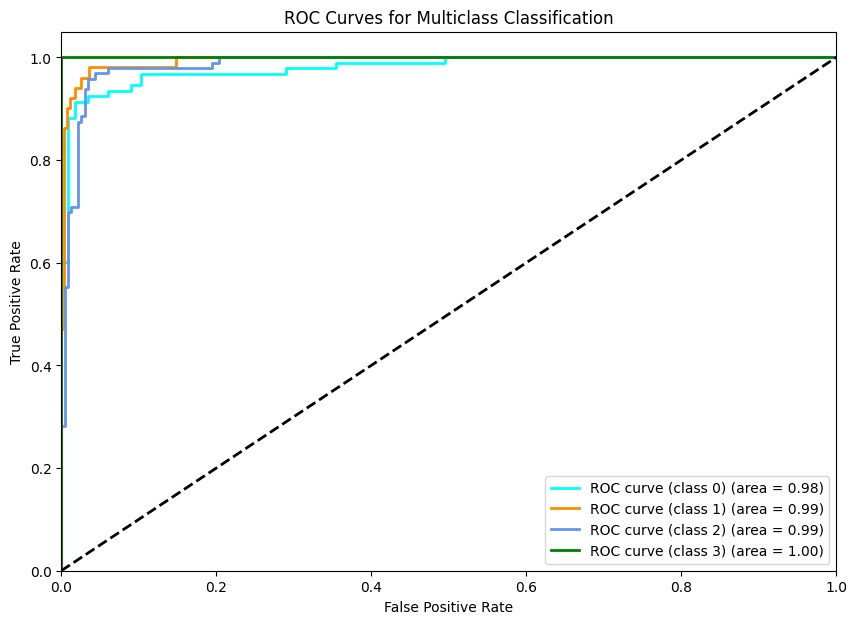

In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the labels for multi-class classification
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])  # 4 classes: [0, 1, 2, 3]
n_classes = y_test_bin.shape[1]

# Get predicted probabilities
y_pred_prob = cnn_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 7))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {i}) (area = {roc_auc[i]:0.2f})')

# Plotting details
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiclass Classification')
plt.legend(loc="lower right")
plt.show()

The ROC curve suggests that our model is learning right but there is some overfitting as the curves are smooth.

We analyse that the paper implementation had the training accuracy of 96.47% and validation accuracy of 93.44% and Our implementation has training accuracy of 97.67% and validation accuracy of 93.27% and so our implementation is correct and the model is learning well in training as well as testing or validation. The output of the confusion matrix, classification report, and ROC curve give us insight about that our model is learning well and will predict better if better techniques other than Traditional CNN. 